In [1]:
import os
import cv2
import numpy as np
from typing import Any, Dict, List, Optional, Tuple
import numpy as np
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import rotate
from skimage.color import rgb2gray
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
import itertools
import glob
import tensorflow as tf
import requests,io
print('TensorFlow version:', tf.__version__)


TensorFlow version: 2.16.1


In [2]:
if not os.path.isfile('./model_resnet.tflite'):
    API_ENDPOINT = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key={}'
    link_r = requests.get(API_ENDPOINT.format('https://disk.yandex.ru/d/QavLH1pvpRhLOA'))
    response= requests.get(link_r.json()['href'])
    if response.status_code == 200:
        with open("./model_resnet.tflite", 'wb') as f:
            f.write(response.content)


In [3]:
tich_file=glob.glob('./Object_Detection/test/*')
print(len(tich_file),tich_file)

5 ['./Object_Detection/test\\my_1.jpg', './Object_Detection/test\\my_2-2.jpg', './Object_Detection/test\\my_4.jpg', './Object_Detection/test\\my_5.jpg', './Object_Detection/test\\my_6.jpg']


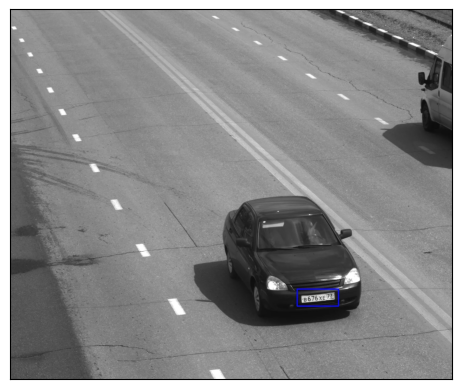

In [4]:
img_name1=tich_file[0]
image = cv2.imread(img_name1)
plt.imshow(image)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

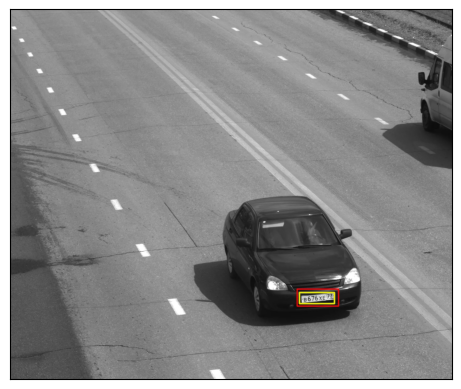

In [5]:
#Загружаем предобученную tflite модель "ssd mobilenet v2 320x320" для нахождения расположения номера машины
i=0
img_name1=tich_file[i]
path = img_name1   
image0 = cv2.imread(img_name1, 1)
image_height, image_width, _ = image0.shape
image = cv2.resize(image0, (1024,1024))
image = image.astype(np.float32)
paths='./model_resnet.tflite'
interpreter = tf.lite.Interpreter(model_path=paths)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
X_data1=np.float32(image.reshape(1,1024, 1024,3))
input_index = (interpreter.get_input_details()[0]['index'])
interpreter.set_tensor(input_details[0]['index'], X_data1)
interpreter.invoke()
detection = interpreter.get_tensor(output_details[0]['index'])
net_out_value2 = interpreter.get_tensor(output_details[1]['index'])
net_out_value3 = interpreter.get_tensor(output_details[2]['index'])
net_out_value4 = interpreter.get_tensor(output_details[3]['index'])
img = image0
razmer=img.shape

img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Converts from one colour space to the other
img3=img[:,:,:]

box_x =int( detection[0,0,0] * image_height)
box_y = int(detection[0,0,1] * image_width)
box_width =int( detection[0,0,2] * image_height)
box_height = int(detection[0,0,3] * image_width)

cv2.rectangle(img2, ( box_y,box_x), (box_height,box_width ), (230, 230, 21), thickness=5)
    
plt.imshow(img2)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()


In [6]:
net_out_value3

array([[0.3433737 , 0.06759817, 0.03687156, 0.02914917, 0.02670897,
        0.02512589, 0.02428008, 0.02227966, 0.01993904, 0.0194088 ]],
      dtype=float32)

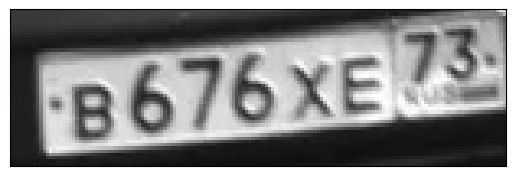

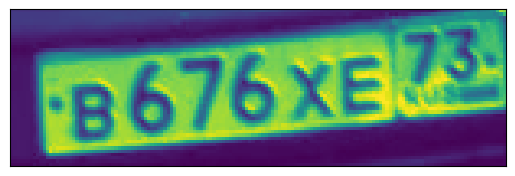

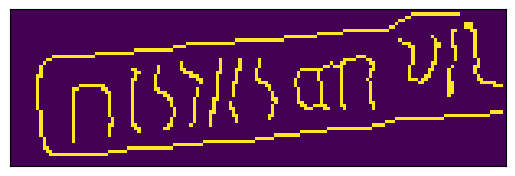

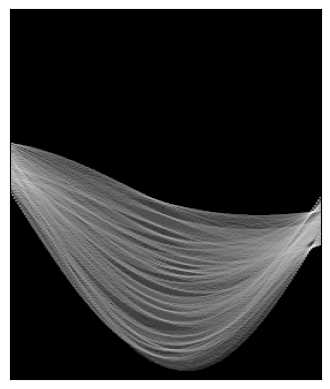

угол наклона -5.5


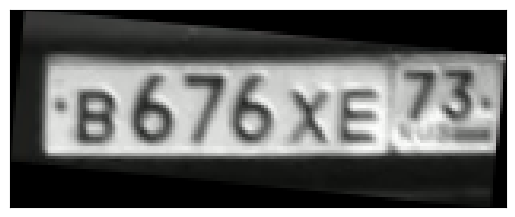

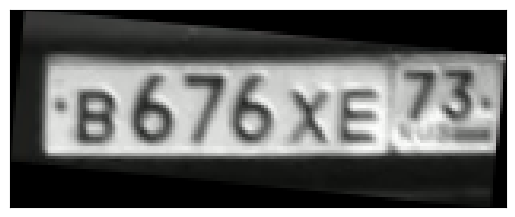

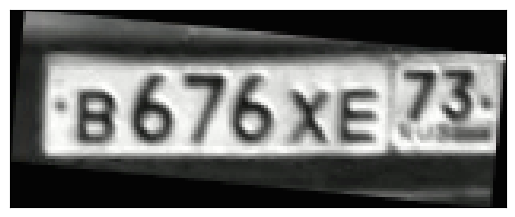

In [7]:
# оставляем только номер
image = image0[box_x:box_width,box_y:box_height,:]
img2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(img2)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

grayscale = rgb2gray(image)
plt.imshow(grayscale)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

edges = canny(grayscale, sigma=3.0)
plt.imshow(edges)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

out, angles, distances = hough_line(edges)
h, theta, d=out, angles, distances 
angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]
plt.imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

_, angles_peaks, _ = hough_line_peaks(out, angles, distances, num_peaks=20)
angle=np.mean(np.rad2deg(angles_peaks))
angle

if 0 <= angle <= 90:
    rot_angle = angle - 90
elif -45 <= angle < 0:
    rot_angle = angle - 90
elif -90 <= angle < -45:
    rot_angle = 90 + angle
if abs(rot_angle)>20:
    rot_angle=0
print('угол наклона',rot_angle )

rotated = rotate(image, rot_angle, resize=True)*255
rotated =rotated.astype(np.uint8)
plt.imshow(rotated)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

rotated1=rotated[:,:,:]
if rotated.shape[1]/rotated.shape[0]<2:
    minus=np.abs(int(np.sin(np.radians(rot_angle))*rotated.shape[0]))
    rotated1=rotated[minus:-minus,:,:]
    print(minus)
plt.imshow(rotated1)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

lab = cv2.cvtColor(rotated1, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
cl = clahe.apply(l)
limg = cv2.merge((cl,a,b))
final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
# final2=rotated1-final
plt.imshow(final)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

In [8]:
import cv2
import numpy as np
import pytesseract

# def preprocess_image(image):
#     # Преобразуем изображение в формат LAB
#     lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    
#     # Разделяем каналы
#     l, a, b = cv2.split(lab)
    
#     # Применяем CLAHE к каналу яркости
#     clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
#     cl = clahe.apply(l)
    
#     # Объединяем каналы обратно
#     limg = cv2.merge((cl,a,b))
    
#     # Преобразуем обратно в формат BGR
#     final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
#     return final

def recognize_text(image):
    # Преобразование изображения в серый масштаб
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Бинаризация изображения
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    # Распознаем текст с использованием Tesseract
    text = pytesseract.image_to_string(thresh, lang='eng')
    
    return text

5 ['./Object_Detection/test\\my_1.jpg', './Object_Detection/test\\my_2-2.jpg', './Object_Detection/test\\my_4.jpg', './Object_Detection/test\\my_5.jpg', './Object_Detection/test\\my_6.jpg']
Распознанный текст: 


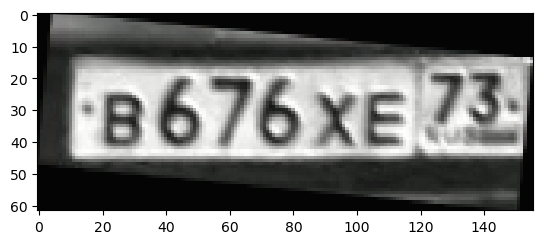

In [11]:
tich_file=glob.glob('./Object_Detection/test/*')
print(len(tich_file),tich_file)
img_name1=tich_file[0]
image = cv2.imread(img_name1)
plt.imshow(image)

# Получение обрезанного изображения
rotated1 = image.copy()
if rotated1.shape[1] / rotated1.shape[0] < 2:
    minus = int(abs(np.sin(np.radians(rot_angle)) * rotated1.shape[0]))
    rotated1 = rotated1[minus:-minus, :, :]

# Предобрабатываем изображение
preprocessed_image = final
plt.imshow(preprocessed_image)

# Распознаём текст
recognized_text = recognize_text(preprocessed_image)
print("Распознанный текст:", recognized_text)

Распознанный номер: ‘B676xE 73,


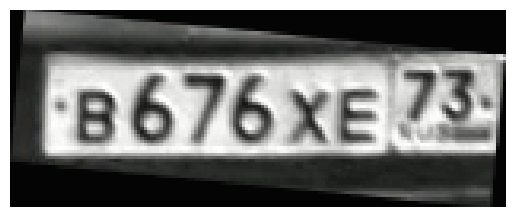